<a href="https://colab.research.google.com/github/adrcynical01/DLI/blob/main/DLI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.0 Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

1.1 Loading Dataset from google drive


1.1A Add CSV file

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: 

1.1B By Address:

In [4]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importing the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/phishing_dataset.csv')

print("Number of total records:", len(dataset))
print()
dataset.head()

Mounted at /content/drive
Number of total records: 11054



,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,Favicon,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,Result
0,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,-1,0,-1,1,-1,-1,1,1,-1,1,...,1,1,1,1,1,-1,1,-1,-1,1


2.0 Preparing the Data

In [5]:
# Separate input features (X) from the target label (y)
# 'Result' is the column that contains the label: 1 = phishing, -1 = legitimate
X = dataset.drop('Result', axis=1).values
y = dataset['Result'].values

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split into training and test sets using stratified sampling to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert labels from -1/1 to 0/1 for binary classification
y_train = np.where(y_train == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

# Optional: Check class distribution to confirm balance
print("Train set class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test set class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Train set class distribution: {np.int64(0): np.int64(3918), np.int64(1): np.int64(4925)}
Test set class distribution: {np.int64(0): np.int64(979), np.int64(1): np.int64(1232)}


3.0 Defining the Neural Network Model

In [7]:
# Importing the Neccessary Libraries for Neural Network

from keras.models import Sequential
from keras.layers import Dense

4.0 Compiling and Training the Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np

# Rebuild the model with more capacity
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # More neurons
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary output

# Print model architecture
model.summary()

# Compile the model using binary crossentropy for binary classification
# 'adam' optimizer adjusts learning efficiently
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting if val_loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compute class weights from training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print("Class Weights:", class_weight_dict)

# Train the model with training data, using 20% for validation
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {np.int64(0): np.float64(1.1285094435936702), np.int64(1): np.float64(0.8977664974619289)}
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8724 - loss: 0.3430 - val_accuracy: 0.9214 - val_loss: 0.1862
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9342 - loss: 0.1656 - val_accuracy: 0.9231 - val_loss: 0.1689
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9432 - loss: 0.1417 - val_accuracy: 0.9276 - val_loss: 0.1575
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9488 - loss: 0.1245 - val_accuracy: 0.9339 - val_loss: 0.1470
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9535 - loss: 0.1110 - val_accuracy: 0.9350 - val_loss: 0.1395
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9575 - loss: 0.1008 - val_accuracy: 0.9367 - val_loss: 0.1339
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9613 - loss: 0.0921 - val_accuracy: 0.9435 - val_loss: 0.129

4.1 Baseline Comparision using Decision Tree

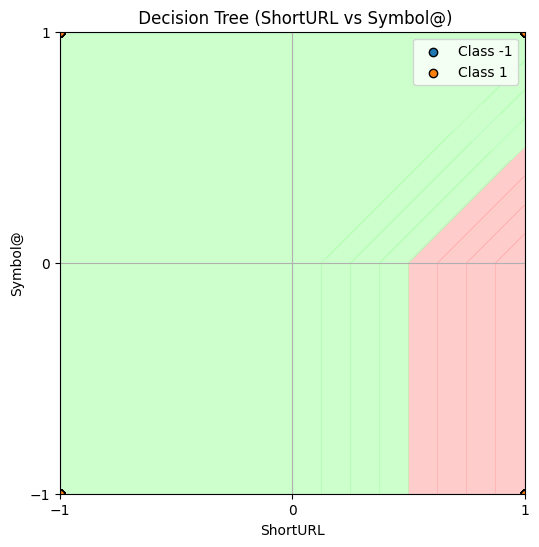

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

# Select 2 binary/categorical features (e.g., ShortURL and Symbol@)
feature_names = ['ShortURL', 'Symbol@']
X_vis = dataset[feature_names].values
y_vis = dataset['Result'].values

# Train a simple decision tree classifier
dt_vis = DecisionTreeClassifier(random_state=42)
dt_vis.fit(X_vis, y_vis)

# Create a discrete meshgrid covering -1 to 1 for both features
xx, yy = np.meshgrid(np.arange(-1, 2, 1), np.arange(-1, 2, 1))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = dt_vis.predict(grid_points).reshape(xx.shape)

# Plot decision surface using discrete levels
plt.figure(figsize=(6, 6))
cmap_bg = ListedColormap(['#FFAAAA', '#AAFFAA'])  # background
plt.contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.6)

# Overlay actual points
for class_value in np.unique(y_vis):
    plt.scatter(X_vis[y_vis == class_value, 0],
                X_vis[y_vis == class_value, 1],
                label=f"Class {class_value}",
                edgecolor='k')

plt.title(" Decision Tree (ShortURL vs Symbol@)")
plt.xlabel('ShortURL')
plt.ylabel('Symbol@')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid(True)
plt.show()


5.0 Model Evaluation

In [10]:
# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (accuracy * 100))


Test Accuracy: 95.79%


6.0 Additional Metrics and Evaluation



70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 Score: 0.9626955475330926
ROC-AUC Score: 0.9931101839937386


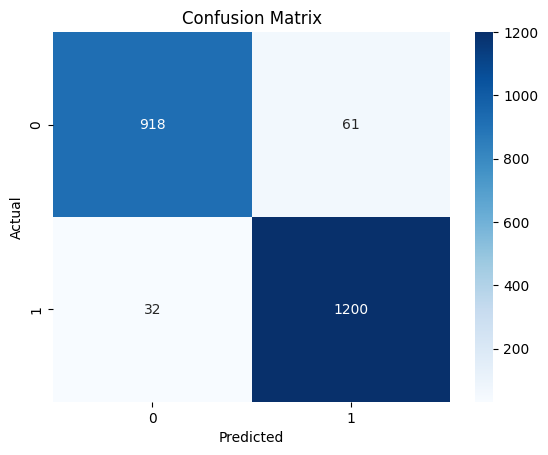

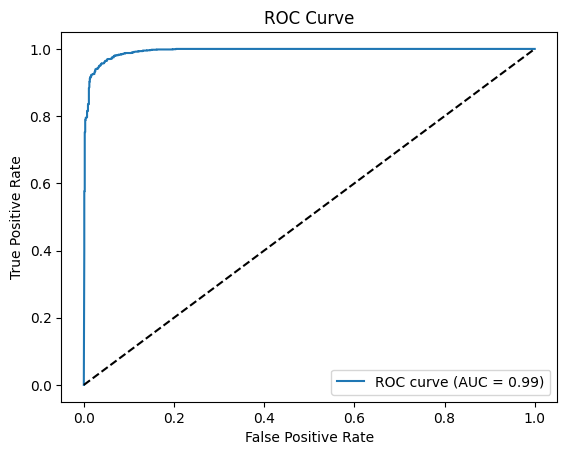

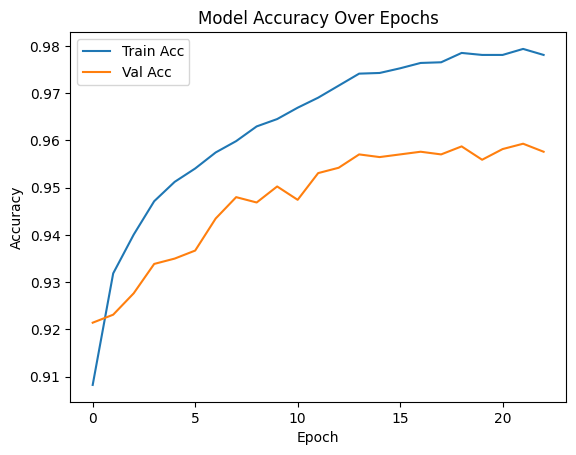

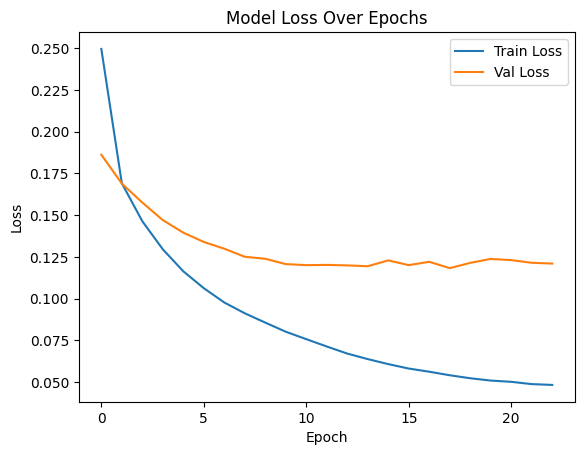

In [11]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities and convert to binary predictions (threshold = 0.5)
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

# Use y_test and y_pred directly (already in 0/1 format)
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [12]:
# Final F1-score verdict
final_f1 = f1_score(y_test, y_pred)
print(f"\n✅ Verdict: Achieved F1 = {final_f1:.2f}, target {'met ✅' if final_f1 >= 0.90 else 'not met ❌'}")



✅ Verdict: Achieved F1 = 0.96, target met ✅


In [13]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Precision: 0.9516256938937351
Recall: 0.974025974025974


7.0 Saving and Loading the Model

In [14]:
# Save the trained model to disk
model.save('phishing_model.keras')

# Later, load the model to reuse without retraining
from keras.models import load_model
loaded_model = load_model('phishing_model.keras')


8.0 Making Prediction

In [15]:
import numpy as np

# List of all 30 feature names (from your dataset)
feature_names = [
    'UsingIP', 'LongURL', 'ShortURL', 'Symbol@', 'Redirecting//', 'PrefixSuffix-', 'SubDomains',
    'HTTPS', 'DomainRegLen', 'Favicon', 'NonStdPort', 'HTTPSDomainURL', 'RequestURL', 'AnchorURL',
    'LinksInScriptTags', 'ServerFormHandler', 'InfoEmail', 'AbnormalURL', 'WebsiteForwarding',
    'StatusBarCust', 'DisableRightClick', 'UsingPopupWindow', 'IframeRedirection', 'AgeofDomain',
    'DNSRecording', 'WebsiteTraffic', 'PageRank', 'GoogleIndex', 'LinksPointingToPage', 'StatsReport'
]

# Prompt the user for each feature value
input_values = []
print("To test the model manually, enter values for each of the 30 features (-1, 0, or 1) below. The model will predict if the website is phishing or legitimate11:")
for name in feature_names:
    while True:
        try:
            val = int(input(f"{name}: "))
            if val in [-1, 0, 1]:
                input_values.append(val)
                break
            else:
                print("Enter only -1, 0, or 1.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

# Convert input to array for prediction
sample_input = np.array([input_values])

# Predict using the loaded model
prediction = loaded_model.predict(sample_input)
predicted_class = np.where(prediction > 0.5, 1, -1)[0][0]

# Print result
if predicted_class == 1:
    print("🔒 This website is predicted to be PHISHING.")
else:
    print("✅ This website is predicted to be LEGITIMATE.")
111

To test the model manually, enter values for each of the 30 features (-1, 0, or 1) below. The model will predict if the website is phishing or legitimate11:
UsingIP: 1
LongURL: 1
ShortURL: 0
Symbol@: 0
Redirecting//: 1
PrefixSuffix-: 
Invalid input. Please enter an integer.
PrefixSuffix-: 
Invalid input. Please enter an integer.
PrefixSuffix-: 1
SubDomains: 1
HTTPS: 1
DomainRegLen: 
Invalid input. Please enter an integer.
DomainRegLen: 1
Favicon: 1
NonStdPort: 1
HTTPSDomainURL: 1
RequestURL: 0
AnchorURL: 0
LinksInScriptTags: 1
ServerFormHandler: 1
InfoEmail: 1
AbnormalURL: 1
WebsiteForwarding: 0
StatusBarCust: 0
DisableRightClick: 1
UsingPopupWindow: 1
IframeRedirection: 1
AgeofDomain: 1
DNSRecording: 1
WebsiteTraffic: 1
PageRank: 0
GoogleIndex: 0
LinksPointingToPage: 1
StatsReport: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
🔒 This website is predicted to be PHISHING.


111